## Setup

In [1]:
import MEArec as mr
import numpy as np
import scipy.optimize
import os
import sys
import re
import ast
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from collections import defaultdict
from joblib import Parallel, delayed

import spikeinterface as si
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
import spikeinterface.comparison as scomp
import spikeinterface.curation as scu

sys.path.append('src')
from src.util_eval import *
from src.util_loc import *

In [2]:
# Overall parameters
mearec_seeds = [42, 43]
dead_indices_seeds = [42, 43, 44]
run_id = f'toy'
sorter_name = 'mountainsort4'
days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5']
methods = ['center_of_mass', 'monopolar_triangulation', 'grid_convolution']
stable_days = 1
dead_electrodes_per_day = 75
gt_toggle = 0 # if 0, use ground truth data as experimental data
correct_radius = 30 # microns

# MEArec parameters
mearec_probe = 'Neuropixels-384'
num_channels = 384
recgen_duration = 15
mearec_noise_level = 10
output_mearec = f'output/{run_id}'

## Figure Charts - Across Seeds

In [3]:
def get_run_params(mearec_seed, dead_indices_seed):

    seed_folder = f'{output_mearec}_{mearec_seed}/seed_{dead_indices_seed}'
    
    # Recording data
    recording_mearec = se.MEArecRecordingExtractor(f'{seed_folder}/D0/recording.h5')
    probe = recording_mearec.get_probe()

    # Waveform extractor data
    wes_gt = []
    for day_i, day in enumerate(days):
        wes_gt.append(si.load_waveforms(f'{output_mearec}_{mearec_seed}/seed_42/{day}/waveforms_gt', with_recording=False))

    # Dead indices
    with open(f'{seed_folder}/dead_indices.pkl', 'rb') as f:
        dead_indices = pickle.load(f)

    # Load tempgen and recgen
    tempgen = mr.load_templates(f'{seed_folder}/templates.h5')
    recgen = mr.load_recordings(f'{seed_folder}/D0/recording.h5')

    # Load templates
    with open(f'{seed_folder}/loc_est_units/loc_est_units.pkl', 'rb') as f:
        loc_est_units = pickle.load(f)
    with open(f'{seed_folder}/loc_est_units/time_units.pkl', 'rb') as f:
        time_units = pickle.load(f)

    # Load spikes
    with open(f'{seed_folder}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
        loc_est_spikes = pickle.load(f)
    with open(f'{seed_folder}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
        time_spikes = pickle.load(f)
    
    electrode_loc = recording_mearec.get_channel_locations()
    unit_loc_true = recgen.template_locations
    
    return wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true

In [4]:
fig_days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5']

fig_days_label = []
for day_i in range(len(fig_days)):
    fig_days_label.append(dead_electrodes_per_day*days.index(fig_days[day_i])/num_channels)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig_method_label = ['COM', 'MT', 'GC']
os.makedirs(f'{output_mearec}', exist_ok=True)

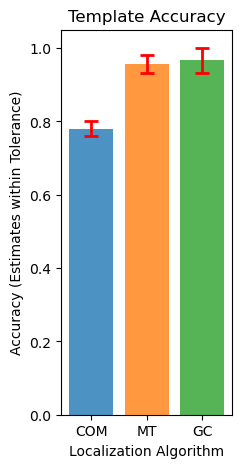

In [5]:
"""Figure 2: Template Accuracy with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_right = 0
        n_wrong = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
            
            unit_loc_est = loc_est_units[method]
            for unit_idx, unit_id in enumerate(we.unit_ids):
                if np.linalg.norm(unit_loc_est[0][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                    n_right += 1
                else:
                    n_wrong += 1
            
        loss_method.append(n_right / (n_right + n_wrong))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))
    
# Create plot
error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')

fig.savefig(f'{output_mearec}/2A_1.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


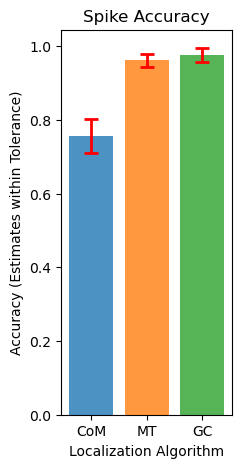

In [6]:
"""Figure 2: Spike Accuracy with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    print(method)
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_right = 0
        n_wrong = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
                        
            unit_loc_est = loc_est_spikes[method][days[we_i]]
            
            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                n_right += unit_n_right
                n_wrong += unit_n_wrong

        loss_method.append(n_right / (n_right + n_wrong))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))    

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
fig.savefig(f'{output_mearec}/2B_1.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


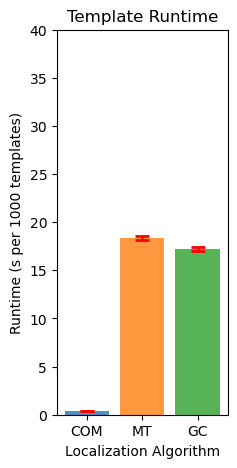

In [7]:
"""Figure 2: Template Runtime with No Dead Electrodes"""

time_mean = []
time_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    print(method)
    
    time_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_templates = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            time_method[mearec_seed_i] += time_units[method]
            n_templates += loc_est_units[method][0].shape[0] * len(loc_est_units[method])
        time_method[mearec_seed_i] = 1000 * time_method[mearec_seed_i] / n_templates
    
    time_mean.append(np.mean(time_method))
    time_std.append(np.std(time_method))

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, time_mean, yerr=time_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template Runtime')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Runtime (s per 1000 templates)')
ax.set_ylim([0, 40])
fig.savefig(f'{output_mearec}/2A_2.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


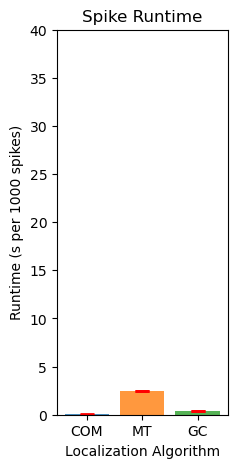

In [8]:
"""Figure 2: Spike Runtime with No Dead Electrodes"""

time_mean = []
time_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))
for method_i, method in enumerate(methods):
    print(method)
    
    time_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_spikes = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            time_method[mearec_seed_i] += time_spikes[method][days[0]]
            for value in loc_est_spikes[method][days[0]][0].values():
                n_spikes += value.shape[0]
                
        time_method[mearec_seed_i] = 1000 * time_method[mearec_seed_i] / n_spikes
    
    time_mean.append(np.mean(time_method))
    time_std.append(np.std(time_method))

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, time_mean, yerr=time_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike Runtime')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Runtime (s per 1000 spikes)')
ax.set_ylim([0, 40])
fig.savefig(f'{output_mearec}/2B_2.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


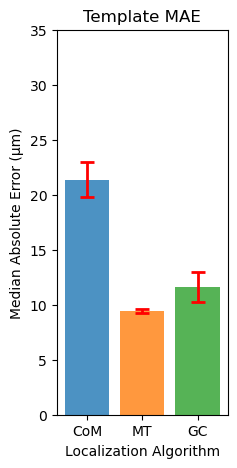

In [ ]:
"""Figure 2: Template MAE with No Dead Electrodes"""

loss_median = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method_i, method in enumerate(methods):
    print(method)
    
    loss_method = []
    all_errors_2 = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        all_errors = []
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_units[method]
            
            # Calculate absolute errors for each template
            diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
            template_errors = np.linalg.norm(diff, axis=1)
            all_errors.extend(template_errors)
            all_errors_2.extend(template_errors)
        
        loss_method.append(np.median(all_errors))

    loss_median.append(np.median(all_errors_2))
    loss_std.append(np.std(loss_method))
    print(f'Method: {method}, Losses: {loss_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_median, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template MAE')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Median Absolute Error (μm)')
ax.set_ylim([0, 70])
fig.savefig(f'{output_mearec}/2A_3.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


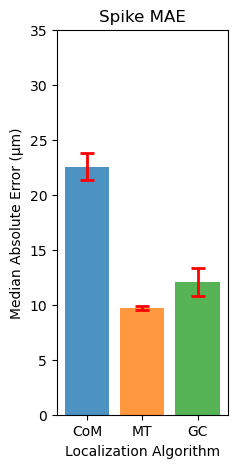

In [ ]:
"""Figure 2: Spike MAE with No Dead Electrodes"""

loss_median = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    print(method)
    
    loss_method = []
    all_errors_2 = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
    
        all_errors = []
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):        
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
            
            unit_loc_est = loc_est_spikes[method][days[we_i]]

            # Calculate absolute errors for each spike
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                spike_locations = unit_loc_est[0][unit_id]
                for spike_loc_est in spike_locations:
                    spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                    diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                    spike_error = np.sqrt(np.sum(diff**2))
                    all_errors.append(spike_error)
                    all_errors_2.append(spike_error)
        
        loss_method.append(np.median(all_errors) if len(all_errors) > 0 else 0)

    loss_median.append(np.median(all_errors_2))
    loss_std.append(np.std(loss_method))
    print(f'Method: {method}, Losses: {loss_method}') # print loss data

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_median, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike MAE')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Median Absolute Error (μm)')
ax.set_ylim([0, 70])
fig.savefig(f'{output_mearec}/2B_3.svg', format='svg', bbox_inches='tight')

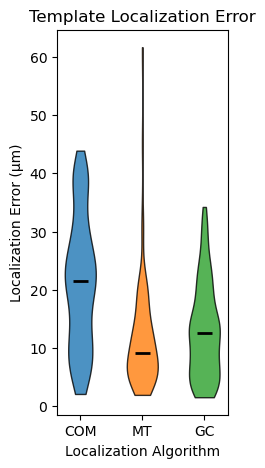

In [11]:
"""Figure 2: Template Error Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method_i, method in enumerate(methods):

    error = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_units[method]
            diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
            error.extend(np.sqrt(np.sum(diff**2, axis=1)))

    loss.append(error)

# Create the violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize the violin plot
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Add median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['COM', 'MT', 'GC'])

ax.title.set_text('Template Localization Error')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Localization Error (μm)')

fig.savefig(f'{output_mearec}/2A_4.svg', format='svg', bbox_inches='tight')

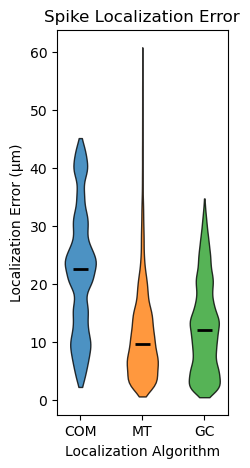

In [ ]:
"""Figure 2: Spike Error Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method in methods:

    day_err = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_spikes[method][days[we_i]]
            
            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                unit_err = get_loss_RMSE_spikes_ind(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
                day_err.extend(unit_err)
            
    day_err.sort()
    day_err = day_err[100:-100] # Exclude lowest and highest 100 errors for violin plot visualization (out of 587737 error values in manuscript dataset, represents 0.034%)
    loss.append(day_err)

# Create the violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize the violin plot
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Add median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['COM', 'MT', 'GC'])

ax.title.set_text('Spike Localization Error')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Localization Error (μm)')

fig.savefig(f'{output_mearec}/2B_4.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5


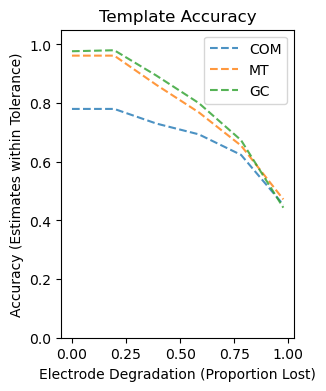

In [13]:
"""Figure 3A: Template Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):
        print(day)
        
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                n_right = 0
                n_wrong = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_units[method]
                    for unit_idx, unit_id in enumerate(we.unit_ids):
                        if np.linalg.norm(unit_loc_est[we_i][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                            n_right += 1
                        else:
                            n_wrong += 1
                    
                loss_day.append(n_right / (n_right + n_wrong))

            loss_mean.append(np.mean(loss_day))

    # Create plot
    loss_mean = np.array(loss_mean)
    method_jit = method_i * 0.005
    ax.plot(fig_days_label, loss_mean + method_jit, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3A_1.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5


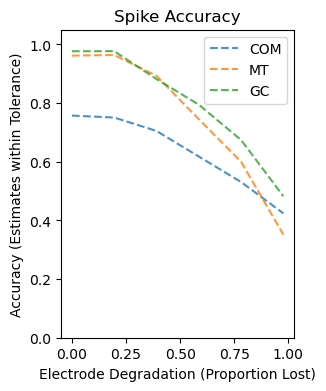

In [14]:
"""Figure 3A: Spike Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
            
                n_right = 0
                n_wrong = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]

                    unit_loc_est = loc_est_spikes[method][days[we_i]]
                    
                    # Calculate loss
                    for unit_idx, unit_id in enumerate(we.unit_ids):
                        unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                        n_right += unit_n_right
                        n_wrong += unit_n_wrong

                loss_day.append(n_right / (n_right + n_wrong))

            loss_mean.append(np.mean(loss_day))

    # Create plot
    ax.plot(fig_days_label, loss_mean, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3B_1.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5


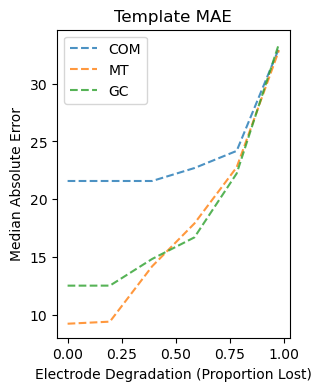

In [15]:
"""Figure 3A: Template MAE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_median = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            all_errors = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_units[method]
                    # Calculate absolute errors for each template
                    diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
                    template_errors = np.linalg.norm(diff, axis=1)
                    all_errors.extend(template_errors)
            
            loss_median.append(np.median(all_errors))

    # Create plot
    loss_median = np.array(loss_median)
    ax.plot(fig_days_label, loss_median, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template MAE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Median Absolute Error')
ax.legend()

fig.savefig(f'{output_mearec}/3A_2.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5
D0
D1
D2
D3
D4
D5


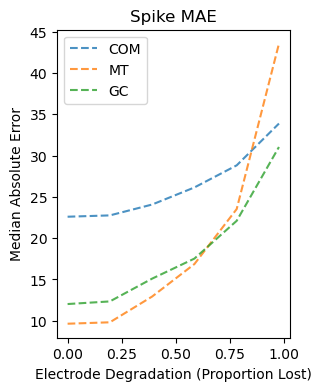

In [16]:
"""Figure 3B: Spike MAE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_median = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            all_errors = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                
                    unit_loc_est = loc_est_spikes[method][day]
                    
                    # Calculate absolute errors for each spike
                    for unit_idx, unit_id in enumerate(we.unit_ids):                
                        spike_locations = unit_loc_est[0][unit_id]
                        for spike_loc_est in spike_locations:
                            spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                            diff = unit_loc_true[unit_idx, 1:] - spike_loc_est
                            spike_error = np.sqrt(np.sum(diff**2))
                            all_errors.append(spike_error)
            
            loss_median.append(np.median(all_errors) if len(all_errors) > 0 else 0)

    # Create plot
    ax.plot(fig_days_label, loss_median, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike MAE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Median Absolute Error')
ax.legend()

fig.savefig(f'{output_mearec}/3B_2.svg', format='svg', bbox_inches='tight')

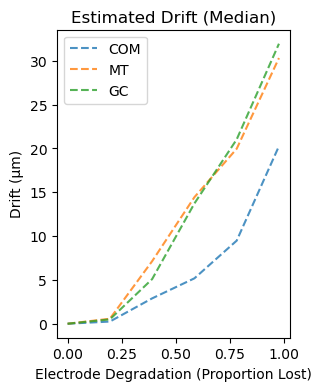

In [17]:
"""Figure 3A: Template Drift (Median)"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_drift = {}

for method in methods:
    estimated_drift[method] = []
    
    for day_i, day in enumerate(days):
        if day in fig_days:
            
            all_drifts = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
                
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    
                    loc_est_unit_0 = loc_est_units[method][0]
                    loc_est_unit = loc_est_units[method][day_i]
                    
                    # Calculate drift for each unit individually
                    unit_drifts = np.linalg.norm(loc_est_unit[:, :2] - loc_est_unit_0[:, :2], axis=1)
                    all_drifts.extend(unit_drifts)
            
            estimated_drift[method].append(np.median(all_drifts) if len(all_drifts) > 0 else 0)
                        
# Create a line plot of the drift for all three localization methods
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_drift[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text('Estimated Drift (Median)')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Drift (μm)')
ax.legend()

fig.savefig(f'{output_mearec}/3A_3.svg', format='svg', bbox_inches='tight')

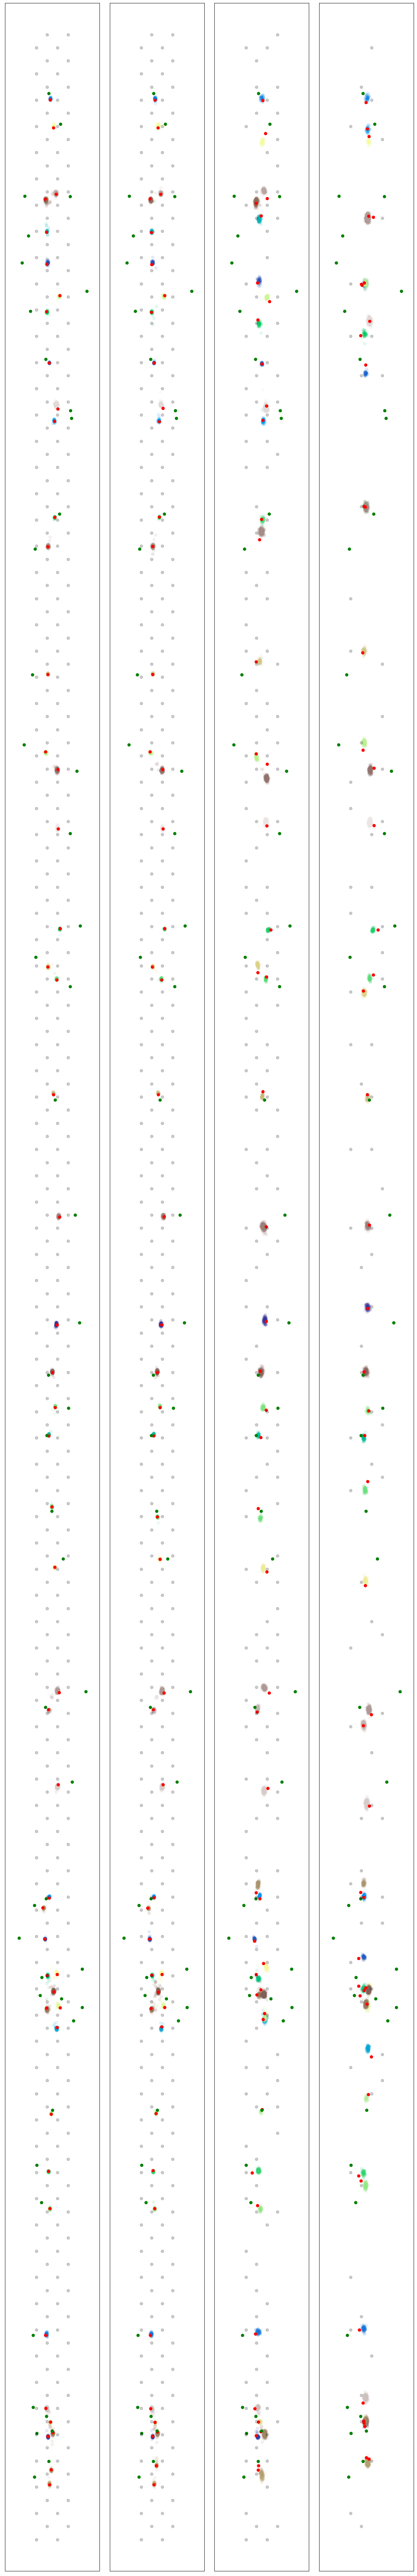

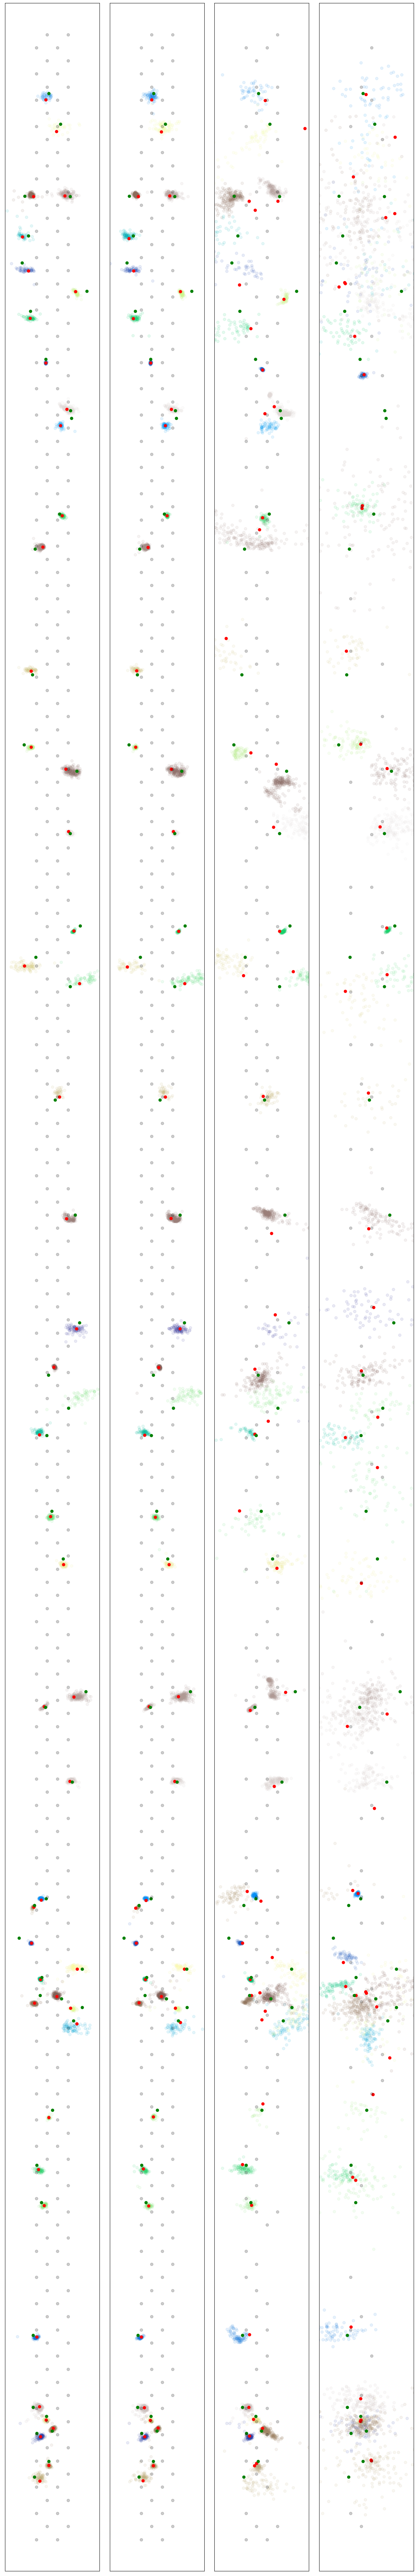

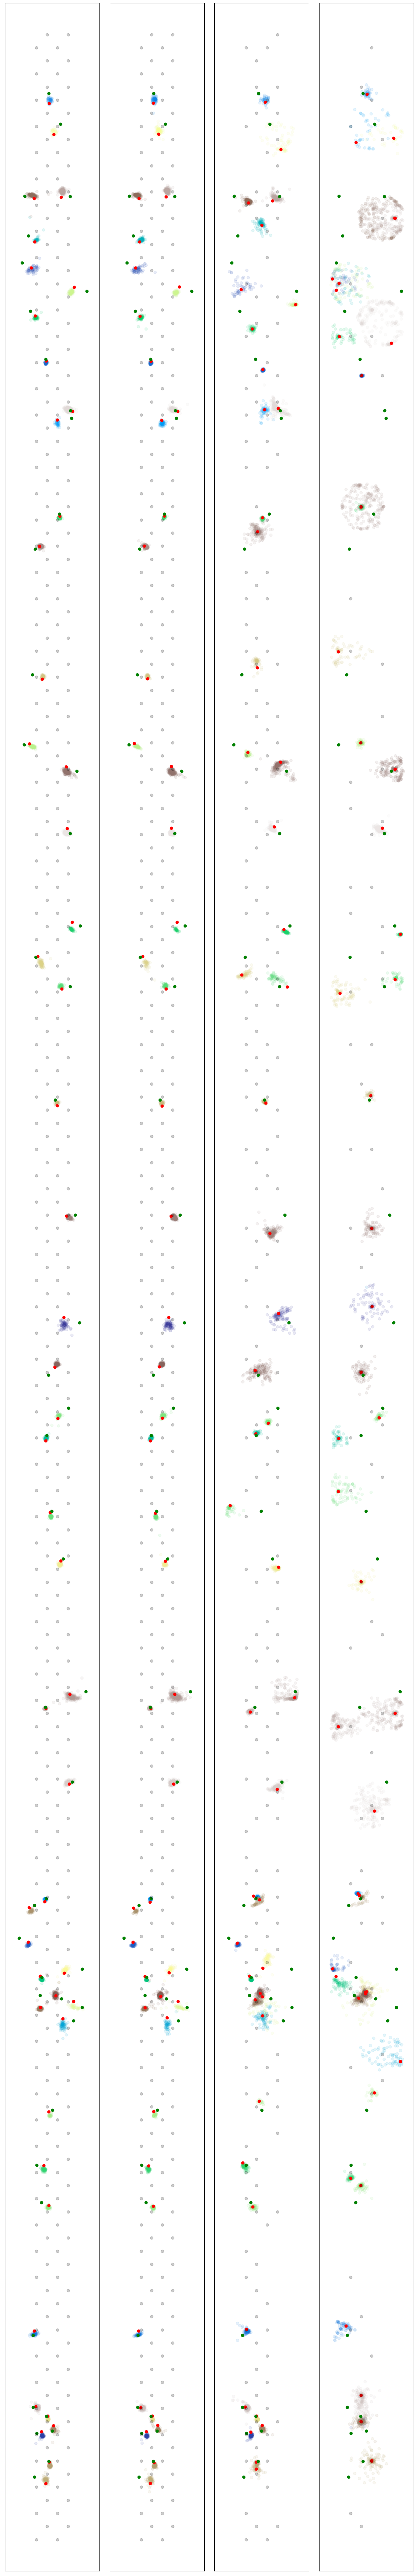

In [20]:
fig_days_2 = ['D0', 'D1', 'D3', 'D5']

for method in methods:

    range_x = electrode_loc[:, 0].max() - electrode_loc[:, 0].min()
    range_y = electrode_loc[:, 1].max() - electrode_loc[:, 1].min()
    range_A = min(range_x, range_y)

    # Create a single row with all days
    col_num = len(fig_days_2)
    fig, axs = plt.subplots(1, col_num, figsize=(4*col_num, 100))  
    plt.subplots_adjust(wspace=0.05)

    for we_i, we in enumerate(wes_gt):
        
        if days[we_i] in fig_days_2:

            loc_est_unit = loc_est_units[method][we_i]
            loc_est_spike = loc_est_spikes[method][days[we_i]]
            
            dead_electrodes = dead_indices[we_i]
            live_electrodes = np.delete(np.arange(electrode_loc.shape[0]), dead_electrodes)

            # Create plot - now using only column index
            col_gt = np.where(np.array(fig_days_2) == days[we_i])[0][0]

            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_loc_est_temp = loc_est_spike[0][unit_id]
                unit_loc_est_temp = np.array(unit_loc_est_temp.tolist())
                axs[col_gt].scatter(unit_loc_est_temp[:, 0], unit_loc_est_temp[:, 1], color=plt.get_cmap('terrain')(unit_idx*5), alpha=0.1, label='Estimated Spikes', rasterized=True)

            axs[col_gt].scatter(loc_est_unit[:, 0], loc_est_unit[:, 1], color='red', label='Estimated Templates')
            axs[col_gt].scatter(unit_loc_true[:, 1], unit_loc_true[:, 2], color='green', label='True Neurons')
            axs[col_gt].scatter(electrode_loc[live_electrodes, 0], electrode_loc[live_electrodes, 1], color=[0, 0, 0], alpha=0.2 , label='Electrodes')
            axs[col_gt].set_xlim([electrode_loc[:, 0].min() - range_A*1.0, electrode_loc[:, 0].max() + range_A*1.0])
            axs[col_gt].set_ylim([electrode_loc[:, 1].min() - range_A*1.0, electrode_loc[:, 1].max() + range_A*1.0])
            axs[col_gt].get_xaxis().set_visible(False)
            axs[col_gt].get_yaxis().set_visible(False)
            axs[col_gt].set_aspect('equal')
    
    fig.savefig(f'{output_mearec}/3C_{method}.svg', format='svg', bbox_inches='tight', dpi=100)

In [19]:
import importlib
import src

importlib.reload(src.util_eval)
from src.util_eval import *